# Alignments and RMS fitting
ref: [link](https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/README.html)


The `MDAnalysis.analysis.align` and `MDAnalysis.analysis.rms` modules contain the functions used for aligning structures, aligning trajectories, and calculating root mean squared quantities.

In [1]:
import MDAnalysis as mda

from MDAnalysis.analysis import align
from MDAnalysis.tests.datafiles import CRD, PSF, DCD, DCD2
import nglview as nv

import warnings
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')
home_path = "/data/home/bty391/Project/QMUL_HPC_note_w_MDAnalysis/Tutorial_notebook"

## Aligning a structure to another
The test files we will be working with here are trajectories of a adenylate kinase (AdK), a phosophotransferase enzyme. ([BDPW09]) The trajectories sample a transition from a closed to an open conformation.

In [2]:
# load the trajectory
adk_open = mda.Universe(CRD, DCD2)
adk_closed = mda.Universe(PSF, DCD)

In [3]:
adk_open_view = nv.show_mdanalysis(adk_open)
adk_open_view


NGLWidget(max_frame=101)

In [4]:
adk_closed_view = nv.show_mdanalysis(adk_closed)
adk_closed_view

NGLWidget(max_frame=97)

Currently, the proteins are not aligned to each other. The difference becomes even more obvious when the closed conformation is compared to the open. Below, we set `adk_open` to the last frame and see the relative positions of each protein in a merged Universe.

In [5]:
adk_open.trajectory[-1] # last frame
merged = mda.Merge(adk_open.atoms, adk_closed.atoms)

merged_view = nv.show_mdanalysis(merged)
merged_view

NGLWidget()

In [6]:
# Aligning a structure with align.alignto

rmsds = align.alignto(adk_open,  # mobile
                      adk_closed,  # reference
                      select='name CA', # selection to operate on
                      match_atoms=True) # whether to match atoms
print(rmsds)
# (old_rmsd, new_rmsd)

(21.712154435976014, 6.817293751703919)


In [7]:
aligned_view = nv.show_mdanalysis(mda.Merge(adk_open.atoms, adk_closed.atoms))
aligned_view

NGLWidget()

However, you may want to align to a structure that where there is not a clear match in particle mass. For example, you could be aligning the alpha-carbons of an atomistic protein to the backbone beads of a coarse-grained structure. Below, we use the somewhat contrived example of aligning 214 alpha-carbons to the first 214 atoms of the reference structure. In this case, we need to switch match_atoms=False or the alignment will error.

In [8]:
rmsds = align.alignto(adk_open.select_atoms('name CA'),  # mobile
                      adk_closed.atoms[:214],  # reference
                      select='all', # selection to operate on
                      match_atoms=False) # whether to match atoms
print(rmsds)

(18.991465038265208, 16.603704620787127)


In [9]:
shifted_aligned_view = nv.show_mdanalysis(mda.Merge(adk_open.atoms, adk_closed.atoms))
shifted_aligned_view

NGLWidget()

When we align structures, positions are set ***temporarily***. If we flip to the first frame of adk_open and back to the last frame, we can see that it has returned to its original location.

In [10]:
adk_open.trajectory[0] # set to first frame
adk_open.trajectory[-1] # set to last frame

< Timestep 101 >

In [11]:
reset_view = nv.show_mdanalysis(mda.Merge(adk_open.atoms, adk_closed.atoms))
reset_view

NGLWidget()

You can save the aligned positions by writing them out to a PDB file and creating a new Universe.

In [13]:
align.alignto(adk_open, adk_closed, select='name CA')
adk_open.atoms.write(f'{home_path}/output/aligned.pdb')
from_file_view = nv.show_mdanalysis(mda.Universe(f'{home_path}/output/aligned.pdb'))
from_file_view

NGLWidget()

## Aligning a trajectory to a reference
Aligning a trajectory with AlignTraj

While `align.alignto` aligns structures, or a frame of a trajectory, `align.AlignTraj` (API docs) efficiently aligns an entire trajectory to a reference. Unlike most other analysis modules, `AlignTraj` allows you to write the output of the analysis to a file. This is because when `Universe`s are created by loading from a file, changes to frame-by-frame (dynamic) information do not persist when the frame is changed. If the trajectory is not written to a file, or pulled into memory (below), `AlignTraj` will have no effect.

In [16]:
# load files
adk_open = mda.Universe(CRD, DCD2)
adk_closed = mda.Universe(PSF, DCD)

adk_open.trajectory[-1] # last frame
merged = mda.Merge(adk_open.atoms, adk_closed.atoms)

In [17]:
align.AlignTraj(adk_closed,  # trajectory to align
                adk_open,  # reference
                select='name CA',  # selection of atoms to align
                filename=f'{home_path}/output/aligned.dcd',  # file to write the trajectory to
                match_atoms=True,  # whether to match atoms based on mass
               ).run()

# merge adk_closed and adk_open into the same universe
merged1 = mda.Merge(adk_closed.atoms, adk_open.atoms)

In [18]:
merged1_view = nv.show_mdanalysis(merged1)
merged1_view

NGLWidget()

In [20]:
aligned = mda.Universe(PSF, f'{home_path}/output/aligned.dcd')
aligned.segments.segids = ['Aligned']  # rename our segments
adk_open.segments.segids = ['Open']  # so they're coloured differently
merged2 = mda.Merge(aligned.atoms, adk_open.atoms)

In [21]:
merged2_view = nv.show_mdanalysis(merged2)
merged2_view

NGLWidget()

`MDAnalysis.Merge` does not automatically load coordinates for a trajectory. We can do this ourselves. Below, we copy the coordinates of the 98 frames in the aligned universe.

In [22]:
from MDAnalysis.analysis.base import AnalysisFromFunction
import numpy as np
from MDAnalysis.coordinates.memory import MemoryReader

def copy_coords(ag):
    return ag.positions.copy()

aligned_coords = AnalysisFromFunction(copy_coords,
                                      aligned.atoms).run().results

print(aligned_coords['timeseries'].shape)

(98, 3341, 3)


In [23]:
# To contrast, we will keep the open conformation static.
adk_coords = adk_open.atoms.positions.copy()
adk_coords.shape

(3341, 3)

In [24]:
# Because there are 98 frames of the aligned Universe, 
# we copy the coordinates of the adk_open positions and stack them.
adk_traj_coords = np.stack([adk_coords] * 98)
adk_traj_coords.shape

(98, 3341, 3)

In [25]:
# We join aligned_coords and adk_traj_coords on the second axis with np.hstack and 
# load the coordinates into memory into the merged2 Universe.
merged_coords = np.hstack([aligned_coords['timeseries'],
                           adk_traj_coords])
merged2.load_new(merged_coords, format=MemoryReader)

<Universe with 6682 atoms>

In [26]:
m2_view = nv.show_mdanalysis(merged2)
m2_view

NGLWidget(max_frame=97)

In [27]:
from nglview.contrib.movie import MovieMaker
movie = MovieMaker(
    m2_view,
    step=4,  # only render every 4th frame
    output=f'{home_path}/output/merged.gif',
    render_params={"factor": 3},  # set to 4 for higher quality
)
movie.make()

IntProgress(value=0, description='Rendering ...', max=24)

## Aligning a trajectory to itself
use `align.AlignTraj` to align a trajectory to a reference frame and write it to a file.

In [29]:
from MDAnalysis.analysis import align, rms

# load files
mobile = mda.Universe(PSF, DCD)
ref = mda.Universe(PSF, DCD)

While `align.alignto` aligns structures, or a frame of a trajectory, `align.AlignTraj` efficiently aligns an entire trajectory to a reference.

We first check the root mean square deviation (RMSD) values of our unaligned trajectory, so we can compare results (please see the linked notebook for an explanation of RMSD). The code below sets the `mobile` trajectory to the last frame by indexing the last timestep, `ref` to the first frame by indexing the first timestep, and computes the root mean squared deviation between the alpha-carbon positions.

In [30]:
mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name CA')
ref_ca = ref.select_atoms('name CA')
unaligned_rmsd = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)
print(f"Unaligned RMSD: {unaligned_rmsd:.2f}")

Unaligned RMSD: 6.84


In [31]:
# load the positions of the trajectory into memory 
# so we can modify the trajectory in Python
aligner = align.AlignTraj(mobile, ref, select='name CA', in_memory=True).run()

In [32]:
# Now we can see that the RMSD has reduced (minorly).

mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name CA')
ref_ca = ref.select_atoms('name CA')
aligned_rmsd = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)

print(f"Aligned RMSD: {aligned_rmsd:.2f}")

Aligned RMSD: 6.81


We can align the trajectory to any frame: for example, the third one. The procedure is much the same, except that we must set ref to the third frame by indexing the third timestep.

In [33]:
mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[2]  # set reference trajectory to third frame

aligned_rmsd_3 = rms.rmsd(mobile.atoms.positions, ref.atoms.positions, superposition=False)

print(f"Aligned RMSD: {aligned_rmsd_3:.2f}")

Aligned RMSD: 6.73


In [34]:
aligner = align.AlignTraj(mobile, ref, select='all', in_memory=True).run()

mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[2]  # set reference trajectory to third frame

aligned_rmsd_3 = rms.rmsd(mobile.atoms.positions, ref.atoms.positions, superposition=False)
print(f"Aligned RMSD, all-atom: {aligned_rmsd_3:.2f}")

Aligned RMSD, all-atom: 6.72


## Calculating the root mean square deviation of atomic structures

In [35]:
import pandas as pd
# the next line is necessary to display plots in Jupyter
%matplotlib inline

In [36]:
u = mda.Universe(PSF, DCD)  # closed AdK (PDB ID: 1AKE)
ref = mda.Universe(PSF, CRD)  # open AdK (PDB ID: 4AKE)

In [37]:
# RMSD between two sets of coordinates
rms.rmsd(u.select_atoms('backbone').positions,  # coordinates to align
         ref.select_atoms('backbone').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates

6.823686867261616

In [38]:
# RMSD of a Universe with multiple selections
CORE = 'backbone and (resid 1-29 or resid 60-121 or resid 160-214)'
LID = 'backbone and resid 122-159'
NMP = 'backbone and resid 30-59'
R = rms.RMSD(u,  # universe to align
             u,  # reference universe or atomgroup
             select='backbone',  # group to superimpose and calculate RMSD
             groupselections=[CORE, LID, NMP],  # groups for RMSD
             ref_frame=0)  # frame index of the reference
R.run()
print(R.results.rmsd.shape)

(98, 6)


In [40]:
# plotting the data
df = pd.DataFrame(R.results.rmsd,
                  columns=['Frame', 'Time (ns)',
                           'Backbone', 'CORE',
                           'LID', 'NMP'])

df.head()

,Frame,Time (ns),Backbone,CORE,LID,NMP
0,0.0,1.0,5.834344e-07,3.921486e-08,1.197000e-07,6.276497e-08
1,1.0,2.0,4.636592e-01,4.550181e-01,4.871915e-01,4.745572e-01
2,2.0,3.0,6.419340e-01,5.754418e-01,7.940994e-01,7.270191e-01
3,3.0,4.0,7.743983e-01,6.739184e-01,1.010261e+00,8.795031e-01
4,4.0,5.0,8.588600e-01,7.318859e-01,1.168397e+00,9.612989e-01


Text(0, 0.5, 'RMSD ($\\AA$)')

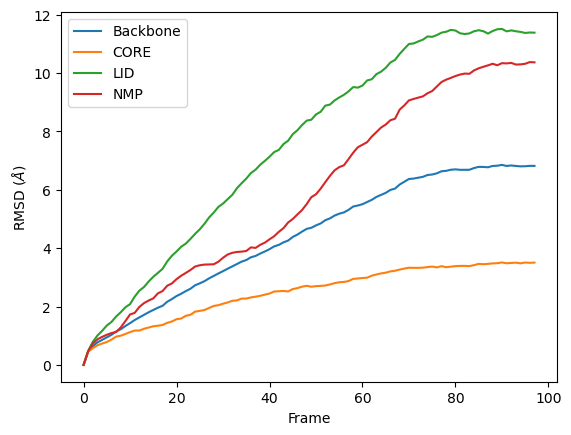

In [41]:
ax = df.plot(x='Frame', y=['Backbone', 'CORE', 'LID', 'NMP'],
             kind='line')
ax.set_ylabel(r'RMSD ($\AA$)')

Text(0, 0.5, 'RMSD ($\\AA$)')

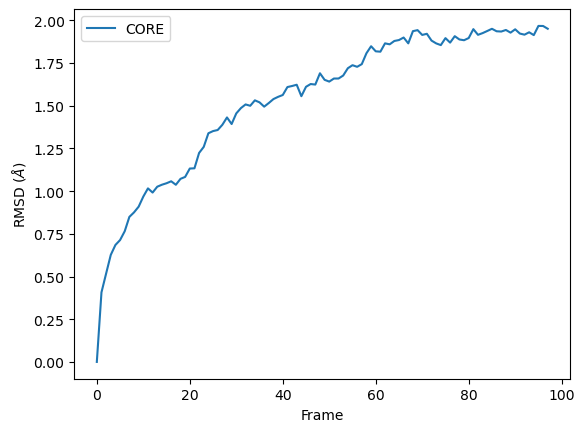

In [42]:
# RMSD of an AtomGroup with multiple selections
ca = u.select_atoms('name CA')

R = rms.RMSD(ca, ca, select=CORE, ref_frame=0)
R.run()

df = pd.DataFrame(R.results.rmsd,
                  columns=['Frame', 'Time (ns)',
                           'CORE'])

ax = df.plot(x='Frame', y='CORE', kind='line')
ax.set_ylabel('RMSD ($\AA$)')

### Weighted RMSD of a trajectory
You can also calculate the weighted RMSD of a trajectory using the `weights` and `weights_groupselections` keywords. The former only applies weights to the group in `select`, while the latter must be a list of the same length and order as `groupselections`. If you would like to only weight certain groups in `groupselections`, use `None` for the unweighted groups. Both `weights` and `weights_groupselections` accept `None` (for unweighted), `'mass'` (to weight by mass), and custom arrays. A custom array should have the same number of values as there are particles in the corresponding AtomGroup.

Text(0, 0.5, 'Mass-weighted RMSD ($\\AA$)')

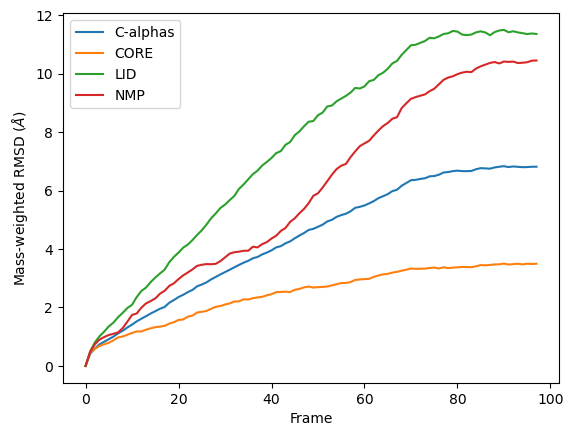

In [43]:
# Mass
R_mass = rms.RMSD(u, u,
                  select='protein and name CA',
                  weights='mass',
                  groupselections=[CORE, LID, NMP])
R_mass.run()

df_mass = pd.DataFrame(R_mass.results.rmsd,
                       columns=['Frame',
                                'Time (ns)',
                                'C-alphas', 'CORE',
                                'LID', 'NMP'])
ax_mass = df_mass.plot(x='Frame',
                       y=['C-alphas', 'CORE', 'LID', 'NMP'])
ax_mass.set_ylabel('Mass-weighted RMSD ($\AA$)')

Shape of C-alpha charges: (214,)


Text(0, 0.5, 'Charge-weighted RMSD ($\\AA$)')

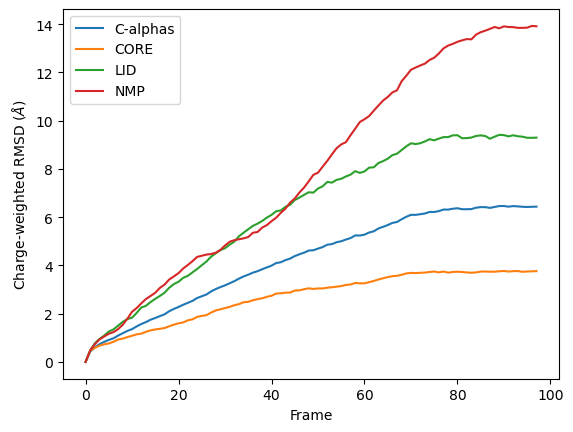

In [44]:
# custom weights
# this is a very non-conventional metric and is shown 
# here simply to demonstrate how to use the code.
ag = u.select_atoms('protein and name CA')
print('Shape of C-alpha charges:', ag.charges.shape)
core = u.select_atoms(CORE)
lid = u.select_atoms(LID)
nmp = u.select_atoms(NMP)

R_charge = rms.RMSD(u, u,
                    select='protein and name CA',
                    groupselections=[CORE, LID, NMP],
                    weights=ag.resids,
                    weights_groupselections=[core.resids,
                                             lid.resids,
                                             nmp.resids])
R_charge.run()

df_charge = pd.DataFrame(R_charge.results.rmsd,
                         columns=['Frame',
                                'Time (ns)',
                                'C-alphas', 'CORE',
                                'LID', 'NMP'])
ax_charge = df_charge.plot(x='Frame',
                           y=['C-alphas', 'CORE', 'LID', 'NMP'])
ax_charge.set_ylabel('Charge-weighted RMSD ($\AA$)')

You can see in the above graph that the NMP domain has much higher RMSD than before, as each particle is weighted by its residue number. Conversely, the CORE domain doesn’t really change much. We could potentially infer from this that residues later in the NMP domain (with a higher residue number) are mobile during the length of the trajectory, whereas residues later in the CORE domain do not seem to contribute significantly to the RMSD.

## Calculating the pairwise RMSD of a trajectory
While 1-dimensional RMSD is a quick way to estimate how much a structure changes over time, it can be a misleading measure. It is easy to think that two structures with the same RMSD from a reference frame are also similar; but in fact, they can be very different. Instead, calculating the RMSD of each frame in the trajectory to all other frames in the other trajectory can contain much more information. This measure is often called the pairwise, all-to-all, or 2D RMSD.

### Pairwise RMSD of a trajectory to itself

In [51]:
from MDAnalysis.analysis import diffusionmap
import matplotlib.pyplot as plt

# load files
adk_open = mda.Universe(CRD, DCD2)
adk_closed = mda.Universe(PSF, DCD)

In [52]:
aligner = align.AlignTraj(adk_open, adk_open, select='name CA',
                          in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(adk_open, select='name CA').run()

matrix.results.dist_matrix.shape # shape: (#n_frames, #n_frame)

(102, 102)

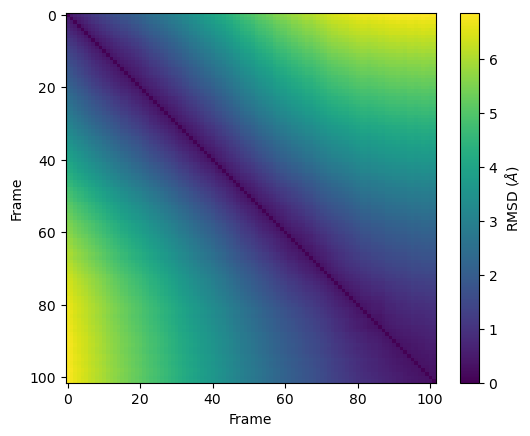

In [53]:
plt.imshow(matrix.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)')

### Pairwise RMSD between two trajectories

In [54]:
# set up a 2D numpy array a shape corresponding to 
# the length of each of our trajectories to store our results. 
prmsd = np.zeros((len(adk_open.trajectory),  # y-axis
                  len(adk_closed.trajectory)))  # x-axis

In [55]:
# Then we iterate through each frame of the adk_open trajectory (our y-axis), and 
# calculate the RMSD of adk_closed to each frame, 
# storing it in the prmsd array.
for i, frame_open in enumerate(adk_open.trajectory):
    r = rms.RMSD(adk_closed, adk_open, select='name CA',
                 ref_frame=i).run()
    prmsd[i] = r.results.rmsd[:, -1]  # select 3rd column with RMSD values

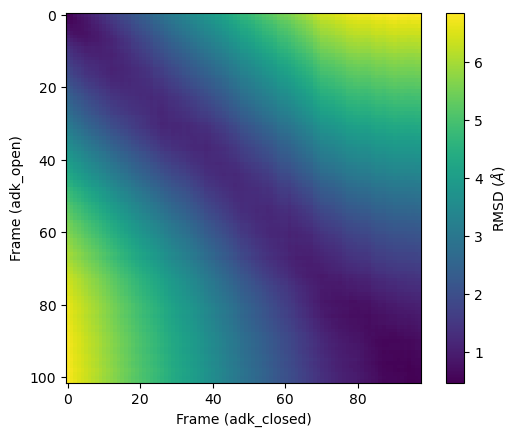

In [56]:
# plot it below
plt.imshow(prmsd, cmap='viridis')
plt.xlabel('Frame (adk_closed)')
plt.ylabel('Frame (adk_open)')
plt.colorbar(label=r'RMSD ($\AA$)')

## Calculating the root mean square fluctuation over a trajectory

In [58]:
from MDAnalysisData import datasets

# load files
adk = datasets.fetch_adk_equilibrium()
u = mda.Universe(adk.topology, adk.trajectory)

adk4AKE.psf: 795kB [00:00, 1.65MB/s]                            
1ake_007-nowater-core-dt240ps.dcd: 168MB [00:02, 79.2MB/s]                              


In [59]:
# create an average structure
average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe

In [60]:
# aligning the trajectory to a reference
aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()


In [61]:
# calculating RMSF
c_alphas = u.select_atoms('protein and name CA')
R = rms.RMSF(c_alphas).run()

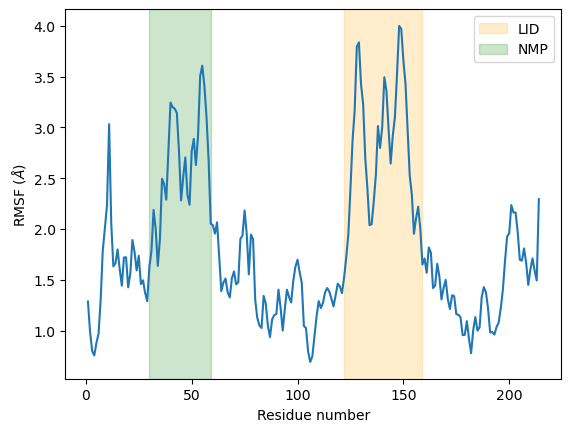

In [62]:
# plotting RMSF
plt.plot(c_alphas.resids, R.results.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='LID')
plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
plt.legend()

In [66]:
# visualising RMSF as B-factors
u.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
protein = u.select_atoms('protein') # select protein atoms
for residue, r_value in zip(protein.residues, R.results.rmsf):
    residue.atoms.tempfactors = r_value

Colouring a protein by RMSF allows you to visually identify regions of high fluctuation. This is commonly done by setting temperature factor (also known as b-factor) values, writing out to a format with B-factor specification (e.g. PDB), and visualising the file in a program such as VMD or nglview.

In [67]:
view = nv.show_mdanalysis(u)
view.update_representation(color_scheme='bfactor')
view

NGLWidget(max_frame=4186)

In [ ]:
u.atoms.write(f'{home_path}/output/rmsf_tempfactors.pdb')